## Chapter 2
### Exploratory Analysis of Bayesian models

### Part 1: A really cool Soccer Example

Or why prior predictive checks matter...



In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

In [2]:
# describe out likelihood function using a custome model based on trig...
half_length = 3.66  # meters
penalty_point = 2  # meters
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))

ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic('p_goal', 2 * Phi(tt.arctan(half_length / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

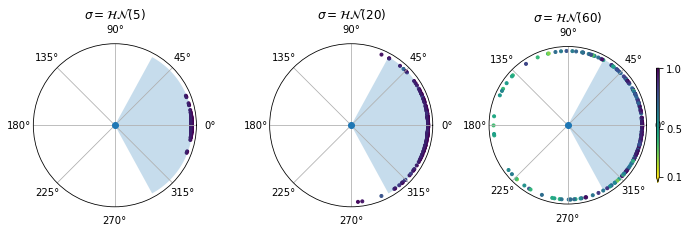

In [3]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(12, 3))

max_angle = np.arctan(half_length/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps["p_goal"] > 0.1
    cax = ax.scatter(pps["α"][cutoff], np.ones_like(pps["α"][cutoff]), c=pps["p_goal"][cutoff],
               marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)